# Pix2Pix GAN 

In [1]:
!pip install torch torchviz matplotlib torchview albumentations

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=43a0b2262e1636df9eb7d099bfc03a0888850d6e4f4ae27bb7a59e7de9e056d7
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import os
import torch
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader


from torchview import draw_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np

torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Discriminator Model

torch.Size([1, 1, 30, 30])


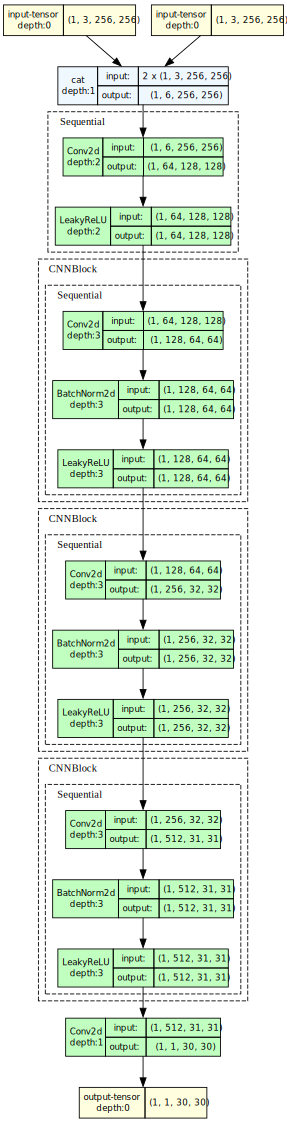

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            
        )

    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64, 128, 256, 512]):
        
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels*2,
                out_channels=features[0],
                kernel_size=4,
                stride = 2,
                padding = 1,
                padding_mode ="reflect",
            ),
            nn.LeakyReLU(0.2),
        )
        
        
        self.layers = nn.ModuleList()
        in_channels = features[0]
        
        for feature in features[1:]:
            self.layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        self.layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        
    
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        for layer in self.layers:
            x = layer(x)
        return x

    
x = torch.randn((1, 3, 256, 256))  
y = torch.randn((1, 3, 256, 256))  
model = Discriminator(in_channels=3)
preds = model(x, y)
print(preds.shape)
architecture = 'Discriminator'
model_graph = draw_graph(model, input_data=(x, y),  
                             graph_dir='TB', roll=True,
                             expand_nested=True, graph_name=f'self_{architecture}', 
                             save_graph=True, filename=f'self_{architecture}')
model_graph.visual_graph



## Generator Model

torch.Size([1, 3, 256, 256])


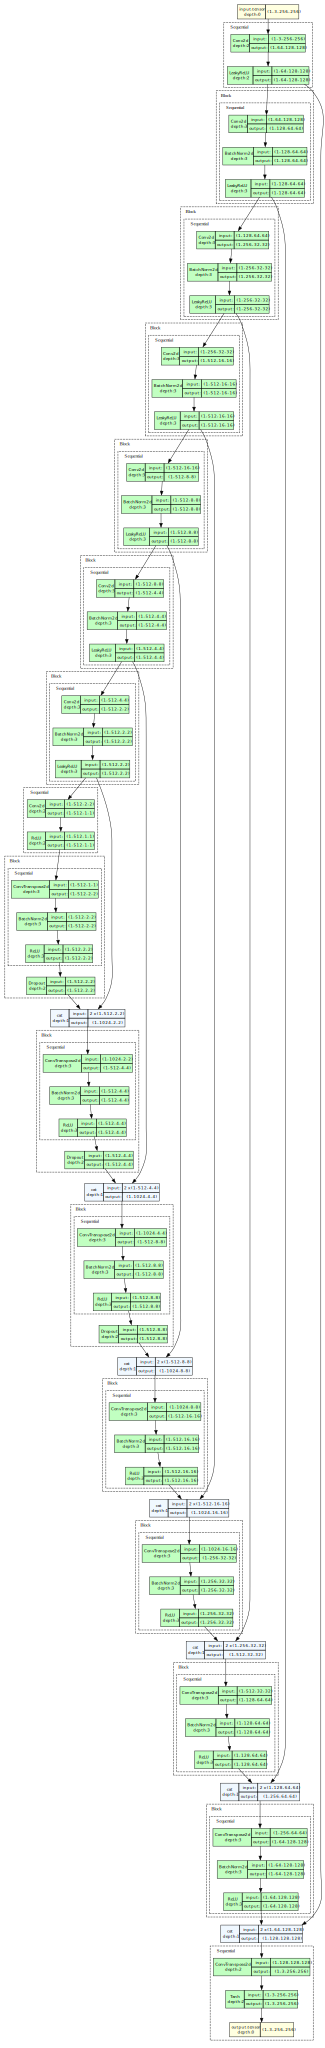

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")  if down  else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4,2,1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4,2,1),
            nn.ReLU(),
        )
        
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))
    

x = torch.randn((1, 3, 256, 256))  
model = Generator(in_channels=3, features=64)
preds = model(x)

print(preds.shape)

architecture = 'Generator'
model_graph = draw_graph(model, input_data=(x,), 
                             graph_dir='TB', roll=True,
                             expand_nested=True, graph_name=f'self_{architecture}', 
                             save_graph=True, filename=f'self_{architecture}')
model_graph.visual_graph

## HYPER PARAMETERS

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/celeberity-faces-dataset/Celebrity Faces Dataset"
VAL_DIR = "/kaggle/input/celeberity-faces-dataset/Celebrity Faces Dataset"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"
DEVICE

'cpu'

In [6]:
both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

## Utils

In [7]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x*0.5+0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y*0.5+0.5, folder+f"/label_{epoch}.png")
    gen.train()
    
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint")
    checkpoint = {
        "state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Load checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Dataset

In [8]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:,:600,:]
        target_image = image[:, 600:, :]
        
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]
        
        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]
        
        return input_image, target

## Train

In [9]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)
        
        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(y)
            D_real = disc(x, y)
            D_real_loos = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            d_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # Train Generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
            
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real = torch.sigmoid(D_real).mean().item(),
                D_fake = torch.sigmoid(D_fake).mean().item()
            )

In [10]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
        
    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        if SAVE_MODEL and epoch % 5==0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
    save_some_examples(gen, val_loader, epoch, folder="EVAL")